In [ ]:
# Mounting the Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Point Colab to the dataset

DATASET_DIR = "/content/cropped_dataset_full"
YAML_PATH   = "/content/oil_tanks.yaml"

print("Dataset dir:", DATASET_DIR)
print("YAML path:", YAML_PATH)


Dataset dir: /content/cropped_dataset_full
YAML path: /content/oil_tanks.yaml


In [1]:
!pip install ultralytics==8.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.13.0.90
    Uninstalling opencv-python-4.13.0.90:
      Successfully uninstalled opencv-python-4.13.0.90
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.37.0

In [1]:
!pip install --upgrade --quiet wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 53.9 MB/s eta 0:00:00


In [2]:
import wandb
wandb.login()

# api key for amish0393: 1f3950b85ee23aacde1b886c5a0446b1f383157d

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amish0393 (amish0393-university-of-birmingham) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# Zip the entire dataset_full directory inside Drive. NO NEED TO RUN AGAIN UNLESS NOT IN DRIVE
# !zip -r /content/drive/MyDrive/Y4_Proj/dataset_full.zip /content/drive/MyDrive/Y4_Proj/dataset_full

# Copy dataset, image & yaml from Google Drive to Colab. DO FOR ZIP FILE AND YAML FILE.
# Update yaml file afterwards for accurate paths
# !cp /content/drive/MyDrive/Y4_Proj/large_cropped.png /content/

# Unzip into Colab. DO JUST FOR ZIP FILE.
# !unzip -q /content/dataset_full.zip -d /content/


In [5]:
# LOAD IMAGE

import cv2

IMAGE_PATH = "/content/large_cropped.png"

img_bgr = cv2.imread(IMAGE_PATH)
if img_bgr is None:
    raise ValueError("Image not found. Check IMAGE_PATH.")

img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

H, W = img.shape[:2]
print("Loaded image size:", (W, H))

# plt.figure(figsize=(6,6))
# plt.imshow(img)
# plt.axis("off")
# plt.show()


Loaded image size: (1504, 1502)


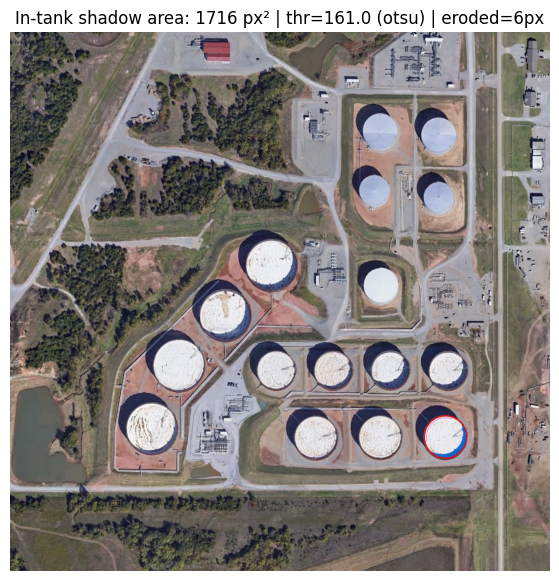

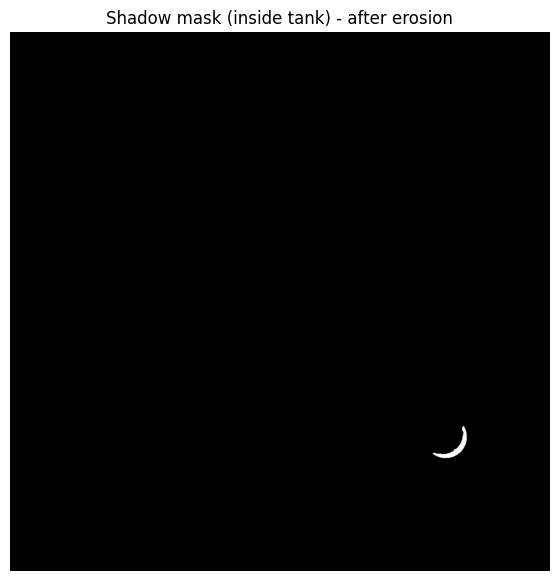

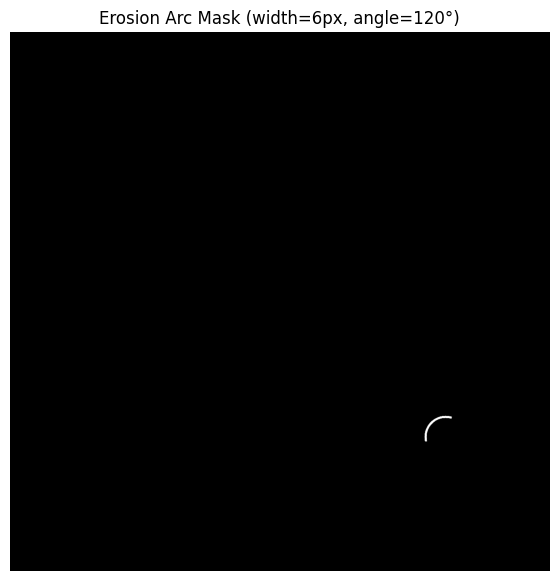

In-tank shadow area (px^2): 1716


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_to_points(mask):
    mask = mask.astype(bool)
    ys, xs = np.where(mask)
    if len(xs) < 10:
        return None
    return np.stack([xs, ys], axis=1).astype(np.float32)

def get_shadow_centroid_and_vector(shadow_mask, tank_center):
    pts = mask_to_points(shadow_mask)
    if pts is None:
        return None, None

    # Calculate centroid
    centroid = pts.mean(axis=0)

    # Calculate vector from tank_center to centroid
    vector = centroid - np.array(tank_center, dtype=np.float32)
    norm = np.linalg.norm(vector)
    if norm < 1e-6:
        # If the centroid is too close to the tank center, direction is ill-defined
        return centroid, None

    unit_vector = vector / norm
    return centroid, unit_vector

def circle_mask(h, w, cx, cy, r):
    yy, xx = np.ogrid[:h, :w]
    return (xx - cx)**2 + (yy - cy)**2 <= r**2

def in_tank_shadow_area_pixels(
    img_rgb,
    cx, cy, r,
    method="otsu",              # "otsu" or "percentile"
    percentile=20,              # used if method="percentile"
    blur_ksize=5,               # odd int: 3,5,7...
    morph_ksize=5,              # morphology kernel size
    erode_tank_edge_pixels=6,   # NEW: thickness of annulus to erode at tank edge
    erosion_angle_degrees=120,  # NEW: angular width of erosion arc
    visualize=True
):
    """
    Returns:
      shadow_area_px: number of shadow pixels inside tank circle
      shadow_mask: boolean mask (H,W) for shadow inside tank
    """
    h, w = img_rgb.shape[:2]
    tank = circle_mask(h, w, cx, cy, r)

    # 1) Luminance channel (LAB L)
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L = lab[:, :, 0]

    # 2) Blur to reduce noise
    if blur_ksize and blur_ksize > 1:
        if blur_ksize % 2 == 0:
            blur_ksize += 1
        Lb = cv2.GaussianBlur(L, (blur_ksize, blur_ksize), 0)
    else:
        Lb = L

    # 3) Threshold computed ONLY within tank
    L_inside = Lb[tank].astype(np.uint8)

    if method == "otsu":
        # Otsu expects a 1D array reshaped to Nx1
        # Correctly capture the threshold value (ret) and discard the thresholded image (dst)
        ret, dst = cv2.threshold(L_inside.reshape(-1, 1), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thr = ret # Use the actual threshold value
        # shadow = darker than threshold
        raw_shadow = (Lb < thr) & tank

    elif method == "percentile":
        thr = np.percentile(L_inside, percentile)
        raw_shadow = (Lb < thr) & tank

    else:
        raise ValueError("method must be 'otsu' or 'percentile'")

    # 4) Morphological cleanup (inside-tank only)
    k = int(morph_ksize)
    if k % 2 == 0: k += 1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))

    shadow_u8 = (raw_shadow.astype(np.uint8) * 255)
    shadow_u8 = cv2.morphologyEx(shadow_u8, cv2.MORPH_OPEN, kernel)
    shadow_u8 = cv2.morphologyEx(shadow_u8, cv2.MORPH_CLOSE, kernel)
    raw_shadow = shadow_u8 > 0

    # NEW: Directional erosion to remove shadow near tank edge opposite to main shadow direction
    shadow = raw_shadow.copy()
    erosion_arc_mask = None # For visualization

    if erode_tank_edge_pixels > 0:
        shadow_centroid, shadow_dir_vector = get_shadow_centroid_and_vector(raw_shadow, (cx, cy))

        if shadow_dir_vector is not None:
            # Calculate shadow angle in radians (from x-axis)
            shadow_angle_rad = np.arctan2(shadow_dir_vector[1], shadow_dir_vector[0])

            # Angle of the arc opposite to the shadow direction
            opposite_angle_rad_center = np.fmod(shadow_angle_rad + np.pi + 2*np.pi, 2*np.pi)
            erosion_angle_rad_half = np.deg2rad(erosion_angle_degrees / 2.0)

            # Define annular region of thickness `erode_tank_edge_pixels` at the tank's circumference
            yy, xx = np.ogrid[:h, :w]
            dist_from_center_sq = (xx - cx)**2 + (yy - cy)**2
            annulus_mask = (dist_from_center_sq > (r - erode_tank_edge_pixels)**2) & (dist_from_center_sq <= r**2)

            # Determine the angular range for erosion
            angle_map_pixels = np.arctan2(yy - cy, xx - cx)
            angle_map_pixels = np.fmod(angle_map_pixels + 2*np.pi, 2*np.pi) # Normalize to [0, 2*pi)

            start_angle = opposite_angle_rad_center - erosion_angle_rad_half
            end_angle = opposite_angle_rad_center + erosion_angle_rad_half

            # Handle angle wrapping around 0/2pi
            if start_angle < 0: start_angle += 2*np.pi
            if end_angle >= 2*np.pi: end_angle -= 2*np.pi

            if start_angle > end_angle: # Range crosses 0/2pi boundary
                angular_arc_mask = (angle_map_pixels >= start_angle) | (angle_map_pixels <= end_angle)
            else:
                angular_arc_mask = (angle_map_pixels >= start_angle) & (angle_map_pixels <= end_angle)

            erosion_arc_mask = annulus_mask & angular_arc_mask
            shadow = raw_shadow & (~erosion_arc_mask) # Remove the arc from the shadow mask

    shadow_area_px = int(shadow.sum())

    if visualize:
        overlay = img_rgb.copy()

        # tint shadow pixels (blue-ish tint)
        overlay[shadow] = (overlay[shadow] * 0.4 + np.array([0, 120, 255]) * 0.6).astype(np.uint8)

        # NEW: Draw erosion arc mask if it was applied
        if erode_tank_edge_pixels > 0 and erosion_arc_mask is not None:
            # Tint the eroded area in a different color (e.g., magenta)
            overlay[erosion_arc_mask & raw_shadow] = (overlay[erosion_arc_mask & raw_shadow] * 0.4 + np.array([255, 0, 255]) * 0.6).astype(np.uint8)
            # Draw the outline of the erosion arc
            overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
            # Highlight the perimeter of the erosion arc
            contours, _ = cv2.findContours(erosion_arc_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(overlay_bgr, contours, -1, (255, 0, 255), 1) # Magenta outline
            overlay = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

        # draw tank circle
        overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
        cv2.circle(overlay_bgr, (int(cx), int(cy)), int(r), (0, 0, 255), 2)
        overlay = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(7,7))
        plt.title(f"In-tank shadow area: {shadow_area_px} px² | thr={thr:.1f} ({method}) | eroded={erode_tank_edge_pixels}px")
        plt.imshow(overlay)
        plt.axis("off")
        plt.show()

        # optional: show the shadow mask alone
        plt.figure(figsize=(7,7))
        plt.title("Shadow mask (inside tank) - after erosion")
        plt.imshow(shadow, cmap="gray")
        plt.axis("off")
        plt.show()

        # NEW: Optionally show the erosion arc mask alone
        if erode_tank_edge_pixels > 0 and erosion_arc_mask is not None:
            plt.figure(figsize=(7,7))
            plt.title(f"Erosion Arc Mask (width={erode_tank_edge_pixels}px, angle={erosion_angle_degrees}°)")
            plt.imshow(erosion_arc_mask, cmap="gray")
            plt.axis("off")
            plt.show()

    return shadow_area_px, shadow


cx, cy = 1213, 1128
r = 59

shadow_area_px, in_shadow_mask = in_tank_shadow_area_pixels(
    img,
    cx, cy, r,
    method="otsu",       # try "percentile" if Otsu struggles
    blur_ksize=5,
    morph_ksize=5,
    #erode_tank_edge_pixels=5,  # Example: erode 5 pixels thick arc
    #erosion_angle_degrees=120, # Example: 120 degree arc
    visualize=True
)

print("In-tank shadow area (px^2):", shadow_area_px)

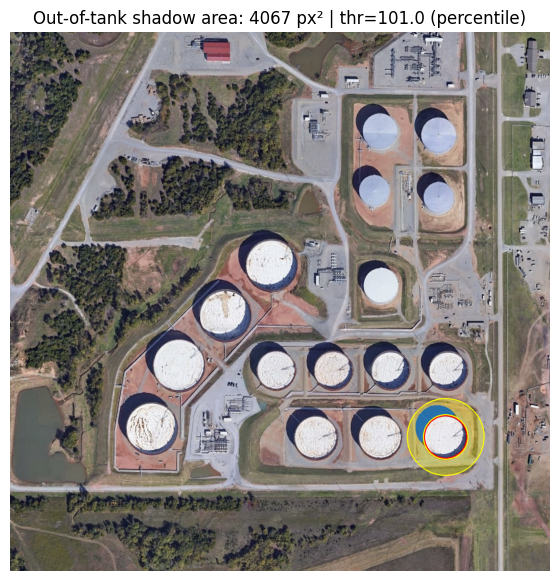

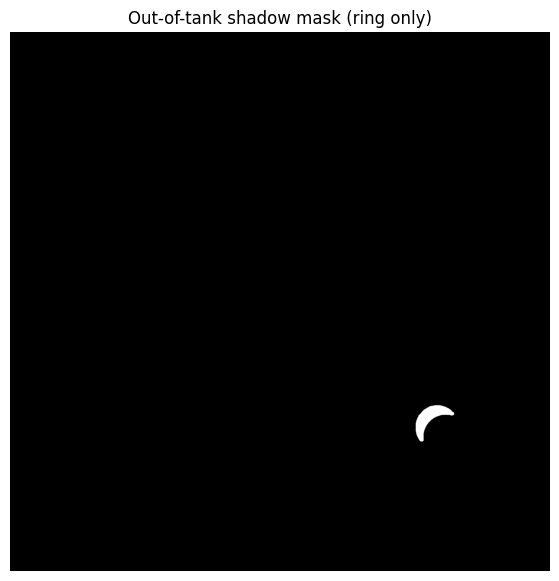

AttributeError: 'str' object has no attribute 'out_shadow_area_px'

In [7]:
# OUT TANK SHADOW AREA CALC

import cv2
import numpy as np
import matplotlib.pyplot as plt

def circle_mask(h, w, cx, cy, r):
    yy, xx = np.ogrid[:h, :w]
    return (xx - cx)**2 + (yy - cy)**2 <= r**2

def ring_mask(h, w, cx, cy, r_inner, r_outer):
    assert r_outer > r_inner, "r_outer must be > r_inner"
    outer = circle_mask(h, w, cx, cy, r_outer)
    inner = circle_mask(h, w, cx, cy, r_inner)
    return outer & (~inner)

def shadow_mask_from_region(img_rgb, region_mask, method="otsu", percentile=20, blur_ksize=5, morph_ksize=5):
    """
    Computes a shadow mask constrained to region_mask using LAB-L channel thresholding.
    Returns: shadow_mask (bool), threshold_value (float)
    """
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L = lab[:, :, 0]

    # blur
    if blur_ksize and blur_ksize > 1:
        if blur_ksize % 2 == 0:
            blur_ksize += 1
        Lb = cv2.GaussianBlur(L, (blur_ksize, blur_ksize), 0)
    else:
        Lb = L

    L_inside = Lb[region_mask].astype(np.uint8)
    if L_inside.size == 0:
        return np.zeros(region_mask.shape, dtype=bool), np.nan

    if method == "otsu":
        # Correctly capture the threshold value (retVal) and discard the thresholded image
        retVal, _ = cv2.threshold(L_inside.reshape(-1, 1), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thr = retVal # Use the actual scalar threshold value
    elif method == "percentile":
        thr = float(np.percentile(L_inside, percentile))
    else:
        raise ValueError("method must be 'otsu' or 'percentile'")

    shadow = (Lb < thr) & region_mask

    # morph cleanup
    k = int(morph_ksize)
    if k % 2 == 0: k += 1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))

    shadow_u8 = (shadow.astype(np.uint8) * 255)
    shadow_u8 = cv2.morphologyEx(shadow_u8, cv2.MORPH_OPEN, kernel)
    shadow_u8 = cv2.morphologyEx(shadow_u8, cv2.MORPH_CLOSE, kernel)

    shadow = shadow_u8 > 0
    return shadow, thr

def out_of_tank_shadow_area_pixels(
    img_rgb,
    cx, cy, r,
    r_outer_scale=1.8,       # outer radius = r_outer_scale * r
    r_inner_scale=1.05,      # inner radius = r_inner_scale * r (excludes tank + small buffer)
    method="otsu",
    percentile=20,
    blur_ksize=5,
    morph_ksize=5,
    visualize=True
):
    """
    Outer region = annulus between r_inner and r_outer.
    Returns: out_shadow_area_px, out_shadow_mask, ring_region
    """
    h, w = img_rgb.shape[:2]
    r_inner = int(np.ceil(r * r_inner_scale))
    r_outer = int(np.ceil(r * r_outer_scale))

    tank = circle_mask(h, w, cx, cy, r)
    ring = ring_mask(h, w, cx, cy, r_inner, r_outer)

    out_shadow, thr = shadow_mask_from_region(
        img_rgb, ring,
        method=method, percentile=percentile,
        blur_ksize=blur_ksize, morph_ksize=morph_ksize
    )

    # safety: ensure tank excluded (should already be excluded by ring)
    out_shadow = out_shadow & (~tank)

    out_area_px = int(out_shadow.sum())

    if visualize:
        overlay = img_rgb.copy()

        # tint ring region lightly (yellow)
        overlay[ring] = (overlay[ring] * 0.7 + np.array([255, 255, 0]) * 0.3).astype(np.uint8)
        # tint out-of-tank shadow (blue)
        overlay[out_shadow] = (overlay[out_shadow] * 0.4 + np.array([0, 120, 255]) * 0.6).astype(np.uint8)

        overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
        cv2.circle(overlay_bgr, (int(cx), int(cy)), int(r), (0, 0, 255), 2)         # tank outline
        cv2.circle(overlay_bgr, (int(cx), int(cy)), int(r_inner), (0, 255, 255), 2) # inner ring
        cv2.circle(overlay_bgr, (int(cx), int(cy)), int(r_outer), (0, 255, 255), 2) # outer ring
        overlay = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(7,7))
        plt.title(f"Out-of-tank shadow area: {out_area_px} px² | thr={thr:.1f} ({method})")
        plt.imshow(overlay)
        plt.axis("off")
        plt.show()

        plt.figure(figsize=(7,7))
        plt.title("Out-of-tank shadow mask (ring only)")
        plt.imshow(out_shadow, cmap="gray")
        plt.axis("off")
        plt.show()

    return out_area_px, out_shadow, ring


cx, cy = 1213, 1128
r = 59

out_shadow_area_px, out_shadow_mask, ring_region = out_of_tank_shadow_area_pixels(
    img, cx, cy, r,
    r_inner_scale=1.05,     # small buffer outside tank edge
    r_outer_scale=1.8,      # how far out to sample background
    method="percentile",
    blur_ksize=10,           # Increased blur to smooth out small noise
    morph_ksize=11,          # Increased kernel size for morphological operations to remove smaller spots
    visualize=True
)

print("Out-of-tank shadow area (px^2):". out_shadow_area_px)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Image size: (1504, 1502)
Post-overlap filter: 19 -> 16
Detections: 16
0 closed_roof_tank conf: 0.933 center: (1015.2, 440.7) r: 44.6
1 closed_roof_tank conf: 0.921 center: (1193.9, 286.5) r: 50.4
2 external_floating_roof_tank conf: 0.918 center: (1033.3, 1130.8) r: 64.0
3 external_floating_roof_tank conf: 0.915 center: (855.4, 1132.2) r: 64.6
4 closed_roof_tank conf: 0.887 center: (1032.5, 274.7) r: 52.0
5 external_floating_roof_tank conf: 0.887 center: (901.3, 943.1) r: 56.6
6 external_floating_roof_tank conf: 0.886 center: (1223.7, 946.2) r: 58.5
7 closed_roof_tank conf: 0.881 center: (1194.9, 460.8) r: 45.3
8 external_floating_roof_tank conf: 0.881 center: (1214.3, 1130.7) r: 6

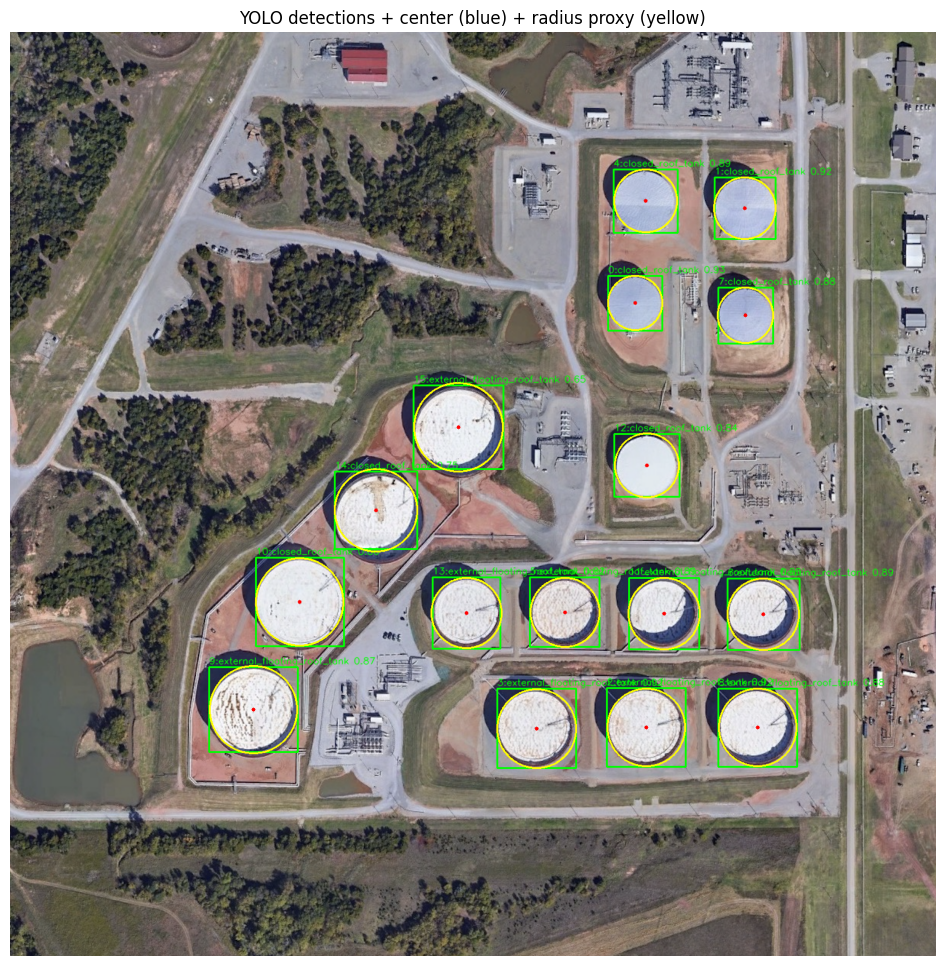

[{'bbox_xyxy': (971.2293090820312,
   396.12872314453125,
   1059.245849609375,
   485.252197265625),
  'center': (1015.237548828125, 440.6904602050781),
  'radius': 44.561737060546875,
  'conf': 0.9333138465881348,
  'cls': 0,
  'name': 'closed_roof_tank'},
 {'bbox_xyxy': (1144.661376953125,
   236.07862854003906,
   1243.1796875,
   336.9546813964844),
  'center': (1193.9205322265625, 286.51666259765625),
  'radius': 50.438026428222656,
  'conf': 0.9213605523109436,
  'cls': 0,
  'name': 'closed_roof_tank'},
 {'bbox_xyxy': (969.3276977539062,
   1066.8773193359375,
   1097.32275390625,
   1194.7467041015625),
  'center': (1033.3251953125, 1130.81201171875),
  'radius': 63.997528076171875,
  'conf': 0.9181020855903625,
  'cls': 1,
  'name': 'external_floating_roof_tank'},
 {'bbox_xyxy': (791.0342407226562,
   1067.5797119140625,
   919.7931518554688,
   1196.841552734375),
  'center': (855.4136962890625, 1132.210693359375),
  'radius': 64.63092041015625,
  'conf': 0.9154133200645447,


In [8]:
#YOLO -> bbox -> (center, radius) for each detected tank, filtering overlaps ---

!pip -q install ultralytics opencv-python

from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
MODEL_PATH = "best.pt"               # put your trained weights in the Colab working dir
IMAGE_PATH = "large_cropped.png"     # your input image
CONF = 0.25                          # tune later if needed
IOU = 0.5                            # tune later if needed
MAX_DET = 300

# -----------------------------
# Load image
# -----------------------------
img_bgr = cv2.imread(IMAGE_PATH)
assert img_bgr is not None, f"Could not read image: {IMAGE_PATH}"
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

H, W = img_rgb.shape[:2]
print("Image size:", (W, H))

# -----------------------------
# Run YOLO
# -----------------------------
model = YOLO(MODEL_PATH)

results = model.predict(
    source=img_rgb,
    conf=CONF,
    iou=IOU,
    max_det=MAX_DET,
    verbose=False
)

r0 = results[0]

# -----------------------------
# Extract detections -> tanks list
# tanks[i] = {
#   "bbox_xyxy": (x1,y1,x2,y2),
#   "center": (cx,cy),
#   "radius": r,
#   "conf": conf,
#   "cls": cls_id,
#   "name": class_name
# }
# -----------------------------
tanks = []
names = model.names if hasattr(model, "names") else {}

if r0.boxes is None or len(r0.boxes) == 0:
    print("No detections.")
else:
    xyxy = r0.boxes.xyxy.cpu().numpy()   # (N,4)
    confs = r0.boxes.conf.cpu().numpy()  # (N,)
    clss  = r0.boxes.cls.cpu().numpy().astype(int)  # (N,)

    for (x1, y1, x2, y2), c, cls_id in zip(xyxy, confs, clss):
        w = float(x2 - x1)
        h = float(y2 - y1)
        cx = float((x1 + x2) / 2.0)
        cy = float((y1 + y2) / 2.0)

        # Radius proxy for a circular tank inside a bbox:
        # half of the smaller side is a robust default but can use max too
        r = 0.5 * max(w, h)

        tanks.append({
            "bbox_xyxy": (float(x1), float(y1), float(x2), float(y2)),
            "center": (cx, cy),
            "radius": float(r),
            "conf": float(c),
            "cls": int(cls_id),
            "name": names.get(int(cls_id), str(int(cls_id)))
        })

# -----------------------------
# Remove overlaps: keep the "better" box
# - higher confidence wins
# - if similar confidence, prefer more square box (tanks ~ circles)
# -----------------------------
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b

    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)

    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h

    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)

    union = area_a + area_b - inter_area
    return 0.0 if union <= 0 else inter_area / union


def squareness_score(bbox_xyxy):
    x1, y1, x2, y2 = bbox_xyxy
    w = max(1e-6, (x2 - x1))
    h = max(1e-6, (y2 - y1))
    # closer to 1 is more square
    ar = w / h
    return 1.0 - abs(np.log(ar))  # penalize aspect ratio away from 1


def dedupe_overlaps_keep_best(tanks, iou_thr=0.5, conf_eps=0.02):
    if not tanks:
        return tanks

    # Sort by confidence first (descending)
    order = sorted(range(len(tanks)), key=lambda i: tanks[i]["conf"], reverse=True)
    picked = []

    for idx in order:
        t = tanks[idx]
        discard = False

        for k in picked:
            iou = iou_xyxy(t["bbox_xyxy"], k["bbox_xyxy"])
            if iou >= iou_thr:
                # overlapping with an already-picked box
                # Decide which is better:
                if t["conf"] < k["conf"] - conf_eps:
                    discard = True
                    break
                elif abs(t["conf"] - k["conf"]) <= conf_eps:
                    # Similar confidence -> prefer squarer (tank-like) box
                    if squareness_score(t["bbox_xyxy"]) <= squareness_score(k["bbox_xyxy"]):
                        discard = True
                        break
                    # else: t is better, but since k is already picked we replace it
                    else:
                        picked.remove(k)
                        break
                else:
                    # t has higher conf than k -> replace k
                    picked.remove(k)
                    break

        if not discard:
            picked.append(t)

    return picked


before = len(tanks)
tanks = dedupe_overlaps_keep_best(tanks, iou_thr=0.6, conf_eps=0.02)
after = len(tanks)
print(f"Post-overlap filter: {before} -> {after}")



print(f"Detections: {len(tanks)}")
for i, t in enumerate(tanks[:10]):
    print(i, t["name"], "conf:", round(t["conf"], 3), "center:", tuple(round(v,1) for v in t["center"]), "r:", round(t["radius"],1))

# -----------------------------
# Visualize overlay
# -----------------------------
vis = img_rgb.copy()

for i, t in enumerate(tanks):
    x1, y1, x2, y2 = map(int, t["bbox_xyxy"])
    cx, cy = map(int, t["center"])
    r = int(t["radius"])

    # bbox
    cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # center point
    cv2.circle(vis, (cx, cy), 3, (255, 0, 0), -1)

    # radius circle (proxy tank outline)
    cv2.circle(vis, (cx, cy), r, (255, 255, 0), 2)

    label = f"{i}:{t['name']} {t['conf']:.2f}"
    cv2.putText(vis, label, (x1, max(15, y1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)



plt.figure(figsize=(12, 12))
plt.imshow(vis)
plt.axis("off")
plt.title("YOLO detections + center (blue) + radius proxy (yellow)")
plt.show()

# tanks is now the output we’ll feed into the shadow pipeline next
tanks


In [11]:
# ============================================================
# FULL PIPELINE (UPDATED AGAIN):
# Adds a hard "belongs-to-this-tank" check:
#   - Only accept a circle candidate if it overlaps the YOLO bbox
#   - Uses circle-vs-rect intersection over circle area (IoC)
# ============================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Sanity checks
# -----------------------------
for fn_name in ["in_tank_shadow_area_pixels", "out_of_tank_shadow_area_pixels"]:  #removed shadow_metrics function from PCA method
    if fn_name not in globals():
        raise NameError(f"Missing function: {fn_name}. Make sure it's defined in a previous cell.")

assert "tanks" in globals() and isinstance(tanks, list), "Expected `tanks` list from YOLO cell."
assert "img_rgb" in globals(), "Expected `img_rgb` from YOLO cell."

H, W = img_rgb.shape[:2]

# ============================================================
# CONFIG
# ============================================================
OUT_DIR = "tank_crops_overlay"
os.makedirs(OUT_DIR, exist_ok=True)

SCALE = 4.0
P2_LIST = [40, 30, 22]
R_MIN_FRAC = 0.4
R_MAX_FRAC = 1.6

ACCEPT_MARGIN = 0.02
MAX_R_UP = 1.20
MIN_UNI = 0.50

# NEW: overlap gate so circle must belong to this YOLO tank
MIN_CIRCLE_IN_BBOX = 0.25   # require at least 25% of circle area overlaps YOLO bbox

# Shadow params
IN_PARAMS = dict(method="otsu", blur_ksize=5, morph_ksize=5, visualize=False)
OUT_PARAMS = dict(r_inner_scale=1.05, r_outer_scale=1.8, method="percentile",
                  blur_ksize=10, morph_ksize=11, visualize=False)

DRAW_YOLO_BBOX = True

# ============================================================
# METRIC HELPERS
# ============================================================
def edge_map(gray):
    return cv2.Canny(gray, 80, 160)

def circle_in_bounds(h, w, cx, cy, r):
    return (cx - r >= 0) and (cy - r >= 0) and (cx + r < w) and (cy + r < h)

def ring_edge_score(edges, cx, cy, r, band=2, n=360):
    h, w = edges.shape[:2]
    thetas = np.linspace(0, 2*np.pi, n, endpoint=False)
    hits, total = 0, 0
    for t in thetas:
        ct, st = np.cos(t), np.sin(t)
        for dr in range(-band, band + 1):
            rr = r + dr
            x = int(round(cx + rr * ct))
            y = int(round(cy + rr * st))
            if 0 <= x < w and 0 <= y < h:
                total += 1
                hits += 1 if edges[y, x] > 0 else 0
    return (hits / total) if total else 0.0

def inside_outside_contrast(gray, cx, cy, r, band=3, n=360):
    h, w = gray.shape[:2]
    thetas = np.linspace(0, 2*np.pi, n, endpoint=False)
    inside, outside = [], []
    rin = max(1, r - band)
    rout = r + band
    for t in thetas:
        ct, st = np.cos(t), np.sin(t)
        x_in  = int(round(cx + rin  * ct))
        y_in  = int(round(cy + rin  * st))
        x_out = int(round(cx + rout * ct))
        y_out = int(round(cy + rout * st))
        if 0 <= x_in < w and 0 <= y_in < h and 0 <= x_out < w and 0 <= y_out < h:
            inside.append(gray[y_in, x_in])
            outside.append(gray[y_out, x_out])
    if not inside or not outside:
        return 0.0
    return float(abs(np.mean(inside) - np.mean(outside)))

def ring_edge_histogram(edges, cx, cy, r, band=2, n_theta=360, n_bins=36):
    h, w = edges.shape[:2]
    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
    hits = np.zeros(n_bins, dtype=np.float32)
    tot  = np.zeros(n_bins, dtype=np.float32)
    for t in thetas:
        b = int((t / (2*np.pi)) * n_bins) % n_bins
        ct, st = np.cos(t), np.sin(t)
        for dr in range(-band, band+1):
            rr = r + dr
            x = int(round(cx + rr * ct))
            y = int(round(cy + rr * st))
            if 0 <= x < w and 0 <= y < h:
                tot[b] += 1.0
                if edges[y, x] > 0:
                    hits[b] += 1.0
    return hits / np.maximum(tot, 1e-6)

def edge_uniformity_score(frac):
    m = float(np.mean(frac))
    if m < 1e-6:
        return 0.0
    cv = float(np.std(frac) / (m + 1e-6))
    return float(np.clip(1.0 - cv / 1.5, 0.0, 1.0))

def total_score(gray, edges, cx, cy, r, crop_center=None):
    if r <= 0:
        return -1e9
    h, w = gray.shape[:2]
    if not circle_in_bounds(h, w, cx, cy, r):
        return -1e9
    s_edge = ring_edge_score(edges, cx, cy, r, band=2, n=360)
    s_con  = inside_outside_contrast(gray, cx, cy, r, band=3, n=360)
    frac   = ring_edge_histogram(edges, cx, cy, r, band=2, n_theta=360, n_bins=36)
    s_uni  = edge_uniformity_score(frac)

    pen = 0.0
    if crop_center is not None:
        ccx, ccy = crop_center
        d = np.hypot(cx - ccx, cy - ccy)
        pen = 0.001 * d

    return 2.0 * s_edge + 1.2 * s_uni + 0.01 * s_con - pen

# ============================================================
# NEW: Circle must overlap YOLO bbox (belongs-to-tank check)
# ============================================================
def circle_rect_intersection_over_circle(cx, cy, r, rx1, ry1, rx2, ry2, samples=720):
    """
    Approximate IoC = (area of circle inside rect) / (area of circle).
    Uses angular sampling on the circle's interior by rasterizing points on the disk boundary is hard;
    Instead we do fast Monte Carlo-like polar sampling on the disk.
    Deterministic sampling for reproducibility.
    """
    if r <= 0:
        return 0.0

    # polar sampling over disk: radii ~ sqrt(u) for uniform area
    n = samples
    # deterministic pseudo-uniform
    us = (np.arange(n) + 0.5) / n
    vs = (np.arange(n) * 0.61803398875) % 1.0  # golden ratio fractional
    rs = r * np.sqrt(us)
    thetas = 2 * np.pi * vs

    xs = cx + rs * np.cos(thetas)
    ys = cy + rs * np.sin(thetas)

    inside = (xs >= rx1) & (xs <= rx2) & (ys >= ry1) & (ys <= ry2)
    return float(np.mean(inside))

# ============================================================
# CIRCLE DETECTION + SELECTION
# ============================================================
def detect_circle_candidates(crop_rgb, r_yolo):
    gray = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 2)

    minR = max(5, int(R_MIN_FRAC * r_yolo))
    maxR = int(R_MAX_FRAC * r_yolo)

    candidates = []
    for p2 in P2_LIST:
        circles = cv2.HoughCircles(
            gray,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=min(gray.shape) // 3,
            param1=120,
            param2=p2,
            minRadius=minR,
            maxRadius=maxR
        )
        if circles is None:
            continue
        circles = np.round(circles[0]).astype(int)
        for (x, y, r) in circles:
            candidates.append((int(x), int(y), int(r), int(p2)))
    return candidates

def choose_geometry_on_crop(crop_rgb, yolo_center_crop, yolo_r, yolo_bbox_crop):
    """
    yolo_bbox_crop: (x1,y1,x2,y2) in crop coords
    """
    gray = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 1.5)
    edges = edge_map(gray)
    h, w = gray.shape[:2]
    crop_center = (w / 2.0, h / 2.0)

    ycx, ycy = map(int, yolo_center_crop)
    yolo_r_i = int(round(yolo_r))
    score_yolo = total_score(gray, edges, ycx, ycy, yolo_r_i, crop_center=crop_center)

    best = None
    best_score = -1e9
    best_uni = 0.0
    best_ioc = 0.0

    rx1, ry1, rx2, ry2 = yolo_bbox_crop

    for (x, y, r, p2) in detect_circle_candidates(crop_rgb, yolo_r):
        # NEW: belongs-to-tank gate (must overlap YOLO bbox)
        ioc = circle_rect_intersection_over_circle(x, y, r, rx1, ry1, rx2, ry2, samples=720)
        if ioc < MIN_CIRCLE_IN_BBOX:
            continue

        s = total_score(gray, edges, x, y, r, crop_center=crop_center)
        if s > best_score:
            frac = ring_edge_histogram(edges, x, y, r, band=2, n_theta=360, n_bins=36)
            uni = edge_uniformity_score(frac)
            best = (x, y, r, p2)
            best_score = s
            best_uni = uni
            best_ioc = ioc

    if best is None:
        return {
            "source": "yolo",
            "cx": ycx, "cy": ycy, "r": yolo_r_i,
            "score_yolo": float(score_yolo),
            "score_circle": None,
            "uni_circle": None,
            "circle_ioc": None,
            "circle_candidate": None
        }

    x, y, r, p2 = best
    circle_ok = (
        (best_score > score_yolo + ACCEPT_MARGIN) and
        (r <= MAX_R_UP * yolo_r) and
        (best_uni >= MIN_UNI)
    )

    if circle_ok:
        src = "circle"; cx, cy, rr = x, y, r
    else:
        src = "yolo";   cx, cy, rr = ycx, ycy, yolo_r_i

    return {
        "source": src,
        "cx": int(cx), "cy": int(cy), "r": int(rr),
        "score_yolo": float(score_yolo),
        "score_circle": float(best_score),
        "uni_circle": float(best_uni),
        "circle_ioc": float(best_ioc),
        "circle_candidate": {"x": int(x), "y": int(y), "r": int(r), "param2": int(p2)}
    }

# ============================================================
# LABEL DRAWING
# ============================================================
def put_label(img_bgr, lines, org=(10, 30), font_scale=0.8, thickness=2, line_gap=28):
    x, y = org
    for k, text in enumerate(lines):
        yy = y + k * line_gap
        cv2.putText(img_bgr, text, (x, yy), cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale, (0, 0, 0), thickness + 2, cv2.LINE_AA)
        cv2.putText(img_bgr, text, (x, yy), cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

# ============================================================
# RUN PIPELINE + SAVE OVERLAID CROPS
# ============================================================
tank_results = []

for i, t in enumerate(tanks):
    cx_full, cy_full = t["center"]
    r_yolo = float(t["radius"])

    # 1) crop around YOLO center
    half = int(SCALE * r_yolo)
    crop_x1 = max(0, int(cx_full) - half)
    crop_y1 = max(0, int(cy_full) - half)
    crop_x2 = min(W, int(cx_full) + half)
    crop_y2 = min(H, int(cy_full) + half)

    crop_rgb = img_rgb[crop_y1:crop_y2, crop_x1:crop_x2].copy()
    if crop_rgb.size == 0:
        continue

    # YOLO center and YOLO bbox in crop coords
    yolo_center_crop = (int(round(cx_full - crop_x1)), int(round(cy_full - crop_y1)))

    bx1, by1, bx2, by2 = t["bbox_xyxy"]
    bx1_c = int(round(bx1 - crop_x1)); by1_c = int(round(by1 - crop_y1))
    bx2_c = int(round(bx2 - crop_x1)); by2_c = int(round(by2 - crop_y1))
    # clip bbox to crop bounds
    bx1_c = max(0, bx1_c); by1_c = max(0, by1_c)
    bx2_c = min(crop_rgb.shape[1]-1, bx2_c); by2_c = min(crop_rgb.shape[0]-1, by2_c)
    yolo_bbox_crop = (bx1_c, by1_c, bx2_c, by2_c)

    # 2) choose geometry WITH overlap gate
    geom = choose_geometry_on_crop(crop_rgb, yolo_center_crop, r_yolo, yolo_bbox_crop)
    cx_c, cy_c, r_c = geom["cx"], geom["cy"], geom["r"]
    center_crop = (cx_c, cy_c)

    # 3) shadows
    in_shadow_area_px, in_shadow_mask = in_tank_shadow_area_pixels(
        crop_rgb, cx_c, cy_c, r_c, **IN_PARAMS
    )
    out_shadow_area_px, out_shadow_mask, ring_region = out_of_tank_shadow_area_pixels(
        crop_rgb, cx_c, cy_c, r_c, **OUT_PARAMS
    )

    # 4) PCA lengths + fill NOTE. OVERRIDDEN PCA WITH RAW AREA CALCS
    if in_shadow_mask.sum() < 5 or out_shadow_mask.sum() < 5:
        metrics = {"shadow_dir": None, "L_out_px": None, "L_in_px": None, "fill_est": None}
    else:
        #metrics = shadow_metrics(in_shadow_mask, out_shadow_mask, center_crop) #this used old PCA method
        # Overwrite fill_est with the requested calculation using raw pixel areas
        if out_shadow_area_px > 1e-6: # Avoid division by zero
            metrics["fill_est"] = np.clip(1.0 - (float(in_shadow_area_px) / float(out_shadow_area_px)), 0, 1) # OVERRIDDEN PCA WITH RAW AREA CALCS
        else:
            metrics["fill_est"] = None

    # 5) draw overlay + save
    crop_vis = crop_rgb.copy()

    circle_color = (0, 255, 0) if geom["source"] == "circle" else (255, 255, 0)  # RGB
    cv2.circle(crop_vis, (cx_c, cy_c), r_c, circle_color, 2)
    cv2.circle(crop_vis, (cx_c, cy_c), 2, (255, 0, 0), -1)

    if DRAW_YOLO_BBOX:
        cv2.rectangle(crop_vis, (bx1_c, by1_c), (bx2_c, by2_c), (0, 255, 0), 2)

    fill = metrics.get("fill_est", None)
    fill_str = "Fill: N/A" if fill is None or (isinstance(fill, float) and (np.isnan(fill) or np.isinf(fill))) else f"Fill: {100.0*float(fill):.1f}%"
    lines = [
        f"Tank {i} ({geom['source']})",
        fill_str,
        f"IoC(circle∩bbox): {geom.get('circle_ioc', None) if geom.get('circle_ioc', None) is not None else 'N/A'}"
    ]

    crop_vis_bgr = cv2.cvtColor(crop_vis, cv2.COLOR_RGB2BGR)
    put_label(crop_vis_bgr, lines, org=(10, 30), font_scale=0.75, thickness=2)

    out_path = os.path.join(OUT_DIR, f"tank_{i:03d}_{geom['source']}.png")
    cv2.imwrite(out_path, crop_vis_bgr)

    tank_results.append({
        "tank_id": i,
        "name": t.get("name"),
        "conf": t.get("conf"),
        "bbox_xyxy_full": t.get("bbox_xyxy"),
        "crop_box_full": (crop_x1, crop_y1, crop_x2, crop_y2),
        "crop_path": out_path,

        "geom_source": geom["source"],
        "center_crop": (float(cx_c), float(cy_c)),
        "radius_crop": float(r_c),

        "score_yolo": geom["score_yolo"],
        "score_circle": geom["score_circle"],
        "uni_circle": geom["uni_circle"],
        "circle_ioc": geom.get("circle_ioc", None),
        "circle_candidate": geom["circle_candidate"],

        "in_shadow_area_px": int(in_shadow_area_px),
        "out_shadow_area_px": int(out_shadow_area_px),

        "in_shadow_mask": in_shadow_mask,
        "out_shadow_mask": out_shadow_mask,

        **metrics
    })

print(f"Done. Overlaid crops saved to '{OUT_DIR}'. Computed results for {len(tank_results)} tanks.")
print("Example output image:", tank_results[0]["crop_path"] if tank_results else "No results")

Done. Overlaid crops saved to 'tank_crops_overlay'. Computed results for 16 tanks.
Example output image: tank_crops_overlay/tank_000_yolo.png


Using stored masks from tank_results for Tank 15
Tank 15 :: IN shadow px = 3746, OUT shadow px = 4760


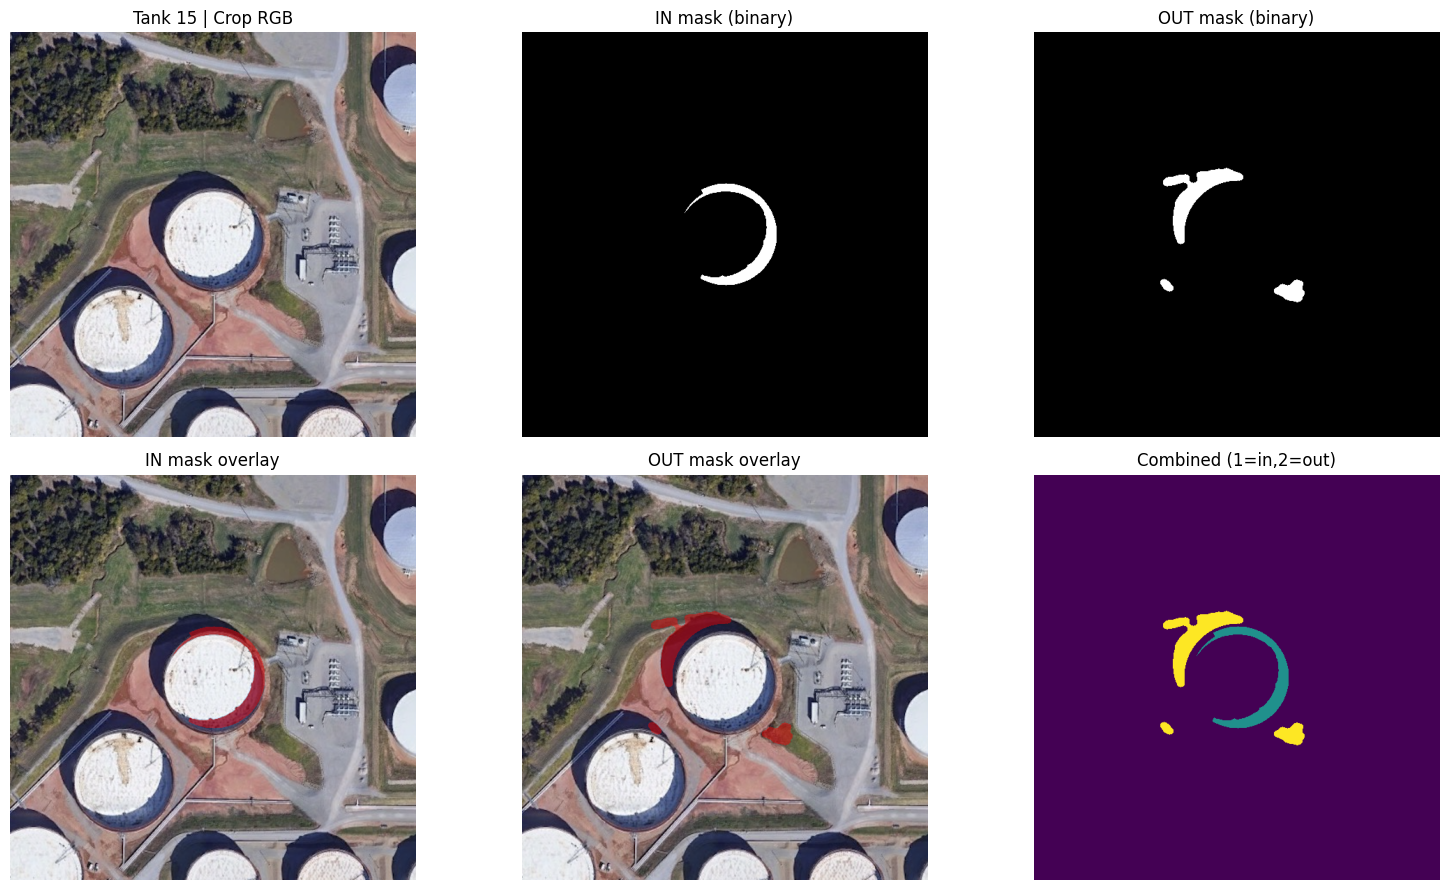

In [17]:
# TESTING SHADOWS


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG: which tank to inspect
# -----------------------------
TANK_ID = 15

# If you want to force rerun shadows even if masks exist in tank_results:
FORCE_RERUN = False

# -----------------------------
# Helpers
# -----------------------------
def overlay_mask_on_rgb(rgb, mask, alpha=0.45):
    """Overlay a binary mask (H,W) on an RGB image."""
    m = (mask > 0).astype(np.uint8)
    overlay = rgb.copy()
    # red overlay
    overlay[m == 1] = (overlay[m == 1] * (1 - alpha) + np.array([255, 0, 0]) * alpha).astype(np.uint8)
    return overlay

def show_triplet(rgb, in_mask, out_mask, title_prefix=""):
    in_mask_u8  = ((in_mask  > 0) * 255).astype(np.uint8)
    out_mask_u8 = ((out_mask > 0) * 255).astype(np.uint8)

    fig, ax = plt.subplots(2, 3, figsize=(16, 9))

    ax[0,0].imshow(rgb); ax[0,0].set_title(f"{title_prefix}Crop RGB"); ax[0,0].axis("off")
    ax[0,1].imshow(in_mask_u8, cmap="gray"); ax[0,1].set_title("IN mask (binary)"); ax[0,1].axis("off")
    ax[0,2].imshow(out_mask_u8, cmap="gray"); ax[0,2].set_title("OUT mask (binary)"); ax[0,2].axis("off")

    ax[1,0].imshow(overlay_mask_on_rgb(rgb, in_mask)); ax[1,0].set_title("IN mask overlay"); ax[1,0].axis("off")
    ax[1,1].imshow(overlay_mask_on_rgb(rgb, out_mask)); ax[1,1].set_title("OUT mask overlay"); ax[1,1].axis("off")

    both = np.clip((in_mask > 0).astype(np.uint8) + 2*(out_mask > 0).astype(np.uint8), 0, 2)
    # 0=none, 1=in, 2=out (if overlaps, out wins visually)
    ax[1,2].imshow(both, cmap="viridis"); ax[1,2].set_title("Combined (1=in,2=out)"); ax[1,2].axis("off")

    plt.tight_layout()
    plt.show()

# -----------------------------
# Main: get crop + geometry + masks for Tank 2
# -----------------------------
assert "img_rgb" in globals(), "Expected img_rgb in globals."
assert "tanks" in globals() and isinstance(tanks, list), "Expected tanks list."
assert TANK_ID < len(tanks), f"TANK_ID={TANK_ID} out of range for tanks (len={len(tanks)})"

# Prefer tank_results if it exists (your pipeline stores masks there)
use_results = ("tank_results" in globals()) and isinstance(tank_results, list) and (TANK_ID < len(tank_results))

if use_results:
    rec = tank_results[TANK_ID]
    crop_x1, crop_y1, crop_x2, crop_y2 = rec["crop_box_full"]
    crop_rgb = img_rgb[crop_y1:crop_y2, crop_x1:crop_x2].copy()

    cx_c, cy_c = map(int, rec["center_crop"])
    r_c = int(round(rec["radius_crop"]))

    have_masks = ("in_shadow_mask" in rec) and ("out_shadow_mask" in rec) and (rec["in_shadow_mask"] is not None) and (rec["out_shadow_mask"] is not None)
else:
    rec = None
    have_masks = False

# If no tank_results or no masks, recompute using the same crop logic + circle-choice logic (if available)
if (not use_results) or FORCE_RERUN or (not have_masks):
    print("Recomputing crop, geometry, and masks for Tank", TANK_ID)

    H, W = img_rgb.shape[:2]
    t = tanks[TANK_ID]
    cx_full, cy_full = t["center"]
    r_yolo = float(t["radius"])

    # crop around YOLO center (same as pipeline)
    SCALE = 4.0
    half = int(SCALE * r_yolo)
    crop_x1 = max(0, int(cx_full) - half)
    crop_y1 = max(0, int(cy_full) - half)
    crop_x2 = min(W, int(cx_full) + half)
    crop_y2 = min(H, int(cy_full) + half)

    crop_rgb = img_rgb[crop_y1:crop_y2, crop_x1:crop_x2].copy()
    assert crop_rgb.size > 0, "Crop is empty; check coordinates."

    # pick geometry if your function exists; otherwise fall back to YOLO
    yolo_center_crop = (int(round(cx_full - crop_x1)), int(round(cy_full - crop_y1)))

    if "choose_geometry_on_crop" in globals():
        geom = choose_geometry_on_crop(crop_rgb, yolo_center_crop, r_yolo)
        cx_c, cy_c, r_c = int(geom["cx"]), int(geom["cy"]), int(geom["r"])
        print("Geometry source:", geom["source"], "| center:", (cx_c, cy_c), "| r:", r_c)
    else:
        cx_c, cy_c = map(int, yolo_center_crop)
        r_c = int(round(r_yolo))
        print("Geometry source: yolo (choose_geometry_on_crop not found)")

    # run shadows
    assert "in_tank_shadow_area_pixels" in globals(), "Missing in_tank_shadow_area_pixels"
    assert "out_of_tank_shadow_area_pixels" in globals(), "Missing out_of_tank_shadow_area_pixels"

    # Use your pipeline params if present; else safe defaults
    IN_PARAMS  = globals().get("IN_PARAMS",  dict(method="otsu", blur_ksize=5, morph_ksize=5, visualize=False))
    OUT_PARAMS = globals().get("OUT_PARAMS", dict(r_inner_scale=1.05, r_outer_scale=1.8, method="percentile", blur_ksize=10, morph_ksize=11, visualize=False))

    in_area_px, in_mask = in_tank_shadow_area_pixels(crop_rgb, cx_c, cy_c, r_c, **IN_PARAMS)
    out_area_px, out_mask, ring_region = out_of_tank_shadow_area_pixels(crop_rgb, cx_c, cy_c, r_c, **OUT_PARAMS)

else:
    print("Using stored masks from tank_results for Tank", TANK_ID)
    in_mask  = rec["in_shadow_mask"]
    out_mask = rec["out_shadow_mask"]
    in_area_px  = int(rec.get("in_shadow_area_px", int((in_mask > 0).sum())))
    out_area_px = int(rec.get("out_shadow_area_px", int((out_mask > 0).sum())))

# -----------------------------
# Display
# -----------------------------
print(f"Tank {TANK_ID} :: IN shadow px = {in_area_px}, OUT shadow px = {out_area_px}")
show_triplet(crop_rgb, in_mask, out_mask, title_prefix=f"Tank {TANK_ID} | ")
